<a href="https://colab.research.google.com/github/miheerdeo/Transformer-for-text-summarization/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl  --quiet

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

In [ ]:
import pandas as pd

news = pd.read_csv("/content/NER_Modified_final.csv")

news



,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...
...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the..."
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...


In [ ]:
first_headline = news.iloc[3]['Short']

print(first_headline)

Mukesh Ambani-led Reliance Industries (RIL) was barred from trading in futures market for a year over stake sale in Reliance Petroleum (RPL). In 2007, RIL sold 4.1% stake in RPL, but shares were first &#39;short-sold&#39; in futures market to avoid a fall in RPL stocks. Short sale means selling shares with plans to buy them back later at lower prices. Reliance Industries Mukesh Ambani-led Reliance Petroleum RIL RPL first &#39;short Reliance Industries Mukesh Ambani-led Reliance Petroleum RIL RPL first &#39;short Reliance Industries Mukesh Ambani-led Reliance Petroleum RIL RPL first &#39;short


In [ ]:
article = news['Short']
summary = news['Headline']
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')#Needed for decoder starts generation from <SOS> and <EOS>

In [ ]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [ ]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76425 29661


In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
       scaled_attention_logits += (mask * -1e6)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)# Cross attention
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model) #maximum length of sequences

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model) #Creates an embedding layer for the decoder's target vocabulary.
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x) #Converts target token IDs to dense vectors.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
d_model = 512  #128
dff = 1024      #512
num_heads = 8   #4
dropout_rate = 0.2
EPOCHS = 15

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [ ]:
import tensorflow as tf

# Assuming `real` and `pred` are tensors of shape (batch_size, max_length, num_classes)

def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
EPOCHS = 25
BATCH_SIZE = 64
subset_dataset = dataset.take(3000) #Redunce the number of samples

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))



Epoch 1 Batch 0 Loss 6.8731 Accuracy 0.1355
Epoch 1 Batch 100 Loss 6.6127 Accuracy 0.1484
Epoch 1 Batch 200 Loss 6.5308 Accuracy 0.1525
Epoch 1 Batch 300 Loss 6.4570 Accuracy 0.1567
Epoch 1 Batch 400 Loss 6.4135 Accuracy 0.1605
Epoch 1 Batch 500 Loss 6.3663 Accuracy 0.1655
Epoch 1 Batch 600 Loss 6.3214 Accuracy 0.1703
Epoch 1 Batch 700 Loss 6.2676 Accuracy 0.1757
Epoch 1 Batch 800 Loss 6.2092 Accuracy 0.1807
Epoch 1 Loss 6.1709 Accuracy 0.1838
Time taken for 1 epoch: 136.23011755943298 secs

Epoch 2 Batch 0 Loss 6.5133 Accuracy 0.1838
Epoch 2 Batch 100 Loss 6.0734 Accuracy 0.1833
Epoch 2 Batch 200 Loss 5.9856 Accuracy 0.1839
Epoch 2 Batch 300 Loss 5.9075 Accuracy 0.1855
Epoch 2 Batch 400 Loss 5.8674 Accuracy 0.1872
Epoch 2 Batch 500 Loss 5.8248 Accuracy 0.1896
Epoch 2 Batch 600 Loss 5.7793 Accuracy 0.1926
Epoch 2 Batch 700 Loss 5.7285 Accuracy 0.1960
Epoch 2 Batch 800 Loss 5.6708 Accuracy 0.1997
Saving checkpoint for epoch 2 at checkpoints/ckpt-2
Epoch 2 Loss 5.6340 Accuracy 0.2020
Tim

In [ ]:
def summarize(input_article):
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)
    return summary_tokenizer.sequences_to_texts(summarized)[0]

In [ ]:
article[5]

'<SOS> A new trailer for the upcoming superhero film  Justice League  was released on Saturday. Based on the DC Comics superhero team, the film stars Ben Affleck as  Batman , Gal Gadot as  Wonder Woman , Ezra Miller as  The Flash  and Jason Momoa as  Aquaman . Directed by Zack Snyder, the film is scheduled to release on November 17, 2017. Ezra Miller superhero film & Ben Affleck DC Comics Zack Snyder Jason Momoa Ezra Miller superhero film & Ben Affleck DC Comics Zack Snyder Jason Momoa Ezra Miller superhero film & Ben Affleck DC Comics Zack Snyder Jason Momoa <EOS>'

In [ ]:
print("Real Summary : ", summary[5][5:-5],"\n Predicted Summary : ", summarize(article[5]))

Real Summary :   New trailer of  Justice League  released  
 Predicted Summary :  new trailer of justice league released


In [ ]:
article[16]

'<SOS> As a part of an education initiative, the entire Wankhede Stadium will be reserved for underprivileged children for the IPL 2017 match between Mumbai Indians and Gujarat Lions, to be held on April 16. A statement by the Mumbai Indians read that they will not be selling any stand tickets for the team s third home game, against the Gujarat Lions. Gujarat Lions the Gujarat Lions Gujarat Lions the Gujarat Lions Gujarat Lions the Gujarat Lions <EOS>'

In [ ]:
print("Real Summary : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))


Real Summary :   Underprivileged kids to fill Wankhede during MI s IPL match  
Predicted Summary :  lions to take place for underprivileged kids


In [ ]:
import numpy as np
import pandas as pd
import random

df = pd.DataFrame(columns=['Article', 'Predicted Summary', 'Actual Summary'])
for _ in range(2000):
    article_id = random.randint(0, len(article) - 1)
    article_text = article[article_id]
    actual_summary = summary[article_id][5:-5]  # Assuming summary is a list of strings
    predicted_summary = summarize(article_text)  # Assuming summarize function is defined elsewhere
    df = pd.concat([df, pd.DataFrame({'Article': [article_id], 'Predicted Summary': [predicted_summary], 'Actual Summary': [actual_summary]})], ignore_index=True)

# Save the DataFrame to a CSV file
df.to_csv('articles_and_summaries.csv', index=False)



In [ ]:
df.head()

,Article,Predicted Summary,Actual Summary
0,33509,award to get bharat ratna for a year,4 Khel Ratna awardees in a year for the 1st t...
1,12609,anna hazare seeks probe into ₹25 000 cr maha g...,"Anna Hazare seeks probe into ₹25,000 cr Maha ..."
2,47932,five migrants drown off greece coast,Five migrants drown off Greek coast
3,10030,i feel bad for india s raees raees sunny,Feel bad that I can t promote Raees in Indi...
4,19202,bengaluru launches lgbt community to support l...,Bengaluru witnesses Pride Parade to support...


In [ ]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ce81304973bc3a028ec695446ff6d9dcfab0c9ceb8c889384df081e48df078a3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
#Testing on Validation set

from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores for each row in the DataFrame
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
for index, row in df.iterrows():
    scores = scorer.score(row['Predicted Summary'], row['Actual Summary'])
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

# Add ROUGE scores to the DataFrame
for metric, scores in rouge_scores.items():
    df[f'{metric}_score'] = scores

# Save the DataFrame with ROUGE scores to a CSV file
df.to_csv('articles_and_summaries_with_rouge_scores.csv', index=False)


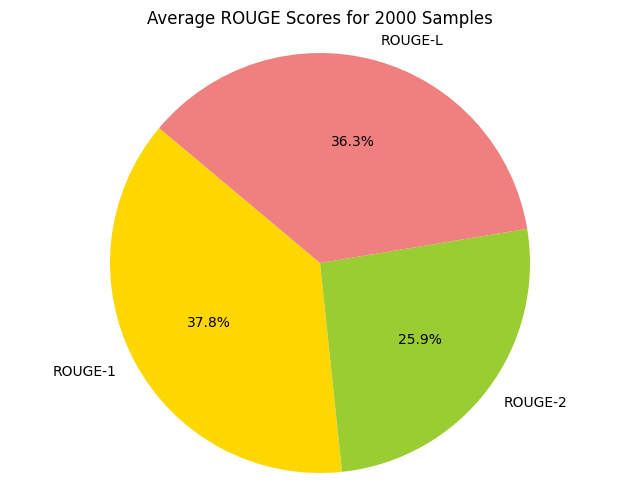

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average ROUGE scores
average_rouge_scores = df[['rouge1_score', 'rouge2_score', 'rougeL_score']].mean()

# Plot a pie chart
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.pie(average_rouge_scores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Average ROUGE Scores for 2000 Samples')
plt.show()


In [ ]:
#Test Cases

text = """
In the Star Trek universe, the USS Enterprise, commanded by Captain James T. Kirk and later Captain Jean-Luc Picard, embarked on exploratory missions across the galaxy. They encountered alien civilizations like the Klingons, Romulans, and Borg, forging alliances and facing conflicts. With technology like warp drive and transporters, they boldly went where no one had gone before, embodying the spirit of curiosity and cooperation."""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  scientists make alliance with scientists predict fear


In [ ]:
text = """
In the Star Trek universe, the USS Enterprise, commanded by Captain James T. Kirk and later Captain Jean-Luc Picard, embarked on exploratory missions across the galaxy. They encountered alien civilizations like the Klingons, Romulans, and Borg, forging alliances and facing conflicts. With technology like warp drive and transporters, they boldly went where no one had gone before, embodying the spirit of curiosity and cooperation.USS Enterprise, Captain James T. Kirk, Captain Jean-Luc Picard, Klingons, Romulans, Borg.USS Enterprise, Captain James T. Kirk, Captain Jean-Luc Picard, Klingons, Romulans, Borg."""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  american man can t game developed


In [ ]:
text = """
In the world of Greek mythology, Zeus, Poseidon, Hades, and Athena were powerful gods who ruled over the heavens, seas, underworld, and wisdom respectively. Their actions and conflicts shaped the myths of ancient Greece, involving epic tales of heroes like Hercules, Perseus, and Odysseus. These myths continue to captivate imaginations, exploring themes of power, destiny, and the human condition."""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  greece changes four former species


In [ ]:
text = """
In the world of Greek mythology, Zeus, Poseidon, Hades, and Athena were powerful gods who ruled over the heavens, seas, underworld, and wisdom respectively. Their actions and conflicts shaped the myths of ancient Greece, involving epic tales of heroes like Hercules, Perseus, and Odysseus. These myths continue to captivate imaginations, exploring themes of power, destiny, and the human condition.Zeus, Poseidon, Hades, Athena, Hercules, Perseus, Odysseus.Zeus, Poseidon, Hades, Athena, Hercules, Perseus, Odysseus.Zeus, Poseidon, Hades, Athena, Hercules, Perseus, Odysseus."""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  greece makes leaves based 80 powerful force


In [ ]:
text = """
In the wizarding world of Harry Potter, Hogwarts School of Witchcraft and Wizardry stood as a beacon of magical education. Harry Potter, along with his friends Hermione Granger and Ron Weasley, navigated their years at Hogwarts, facing challenges from dark forces like Lord Voldemort and his Death Eaters. They were guided by mentors like Albus Dumbledore and Severus Snape, and aided by allies such as Sirius Black, Remus Lupin, and the Order of the Phoenix. Their adventures took them to magical places like Diagon Alley, Hogsmeade, and the Forbidden Forest, where they encountered creatures like Hippogriffs, Dementors, and the Hungarian Horntail dragon. Through courage, friendship, and the power of love, they triumphed over evil and restored peace to the wizarding world."""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  new harry potter themed school syllabus


In [ ]:
text = """
In the wizarding world of Harry Potter, Hogwarts School of Witchcraft and Wizardry stood as a beacon of magical education. Harry Potter, along with his friends Hermione Granger and Ron Weasley, navigated their years at Hogwarts, facing challenges from dark forces like Lord Voldemort and his Death Eaters. They were guided by mentors like Albus Dumbledore and Severus Snape, and aided by allies such as Sirius Black, Remus Lupin, and the Order of the Phoenix. Their adventures took them to magical places like Diagon Alley, Hogsmeade, and the Forbidden Forest, where they encountered creatures like Hippogriffs, Dementors, and the Hungarian Horntail dragon. Through courage, friendship, and the power of love, they triumphed over evil and restored peace to the wizarding world.Hogwarts School of Witchcraft and Wizardry, Harry Potter, Hermione Granger, Ron Weasley, Lord Voldemort, Death Eaters, Albus Dumbledore, Severus SnapeHogwarts School of Witchcraft and Wizardry, Harry Potter, Hermione Granger, Ron Weasley, Lord Voldemort, Death Eaters, Albus Dumbledore, Severus Snape"""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  new harry potter themed school syllabus


In [ ]:
text = """
In the world of Marvel comics, the Avengers, including Iron Man, Captain America, Thor, Black Widow, and Hulk, united to protect Earth from threats like Loki, Ultron, and Thanos. They collaborated with allies such as S.H.I.E.L.D., Nick Fury, and the Guardians of the Galaxy. Their battles spanned iconic locations like New York City, Asgard, and Wakanda, showcasing their superpowers and unwavering determination to defend humanity"""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  new spider man plays guitar in the united states


In [ ]:
text = """
In the world of Marvel comics, the Avengers, including Iron Man, Captain America, Thor, Black Widow, and Hulk, united to protect Earth from threats like Loki, Ultron, and Thanos. They collaborated with allies such as S.H.I.E.L.D., Nick Fury, and the Guardians of the Galaxy. Their battles spanned iconic locations like New York City, Asgard, and Wakanda, showcasing their superpowers and unwavering determination to defend humanity.Avengers, Iron Man, Captain America, Thor, Black Widow, Hulk, Loki, Ultron, ThanosAvengers, Iron Man, Captain America, Thor, Black Widow, Hulk, Loki, Ultron, Thanos"""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  us man plays moon as terror threat


In [ ]:
text = """
In the world of literature, Sherlock Holmes, a brilliant detective created by Sir Arthur Conan Doyle, solved mysteries alongside his trusted companion Dr. John Watson. Together, they tackled cases involving notable characters like Professor Moriarty, Irene Adler, and the Hound of the Baskervilles. Their adventures took place in iconic settings such as 221B Baker Street, the streets of London, and the moors of Dartmoor, showcasing Holmes' deductive prowess and Watson's steadfast loyalty"""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  british author developed as community


In [ ]:
text = """
In the world of literature, Sherlock Holmes, a brilliant detective created by Sir Arthur Conan Doyle, solved mysteries alongside his trusted companion Dr. John Watson. Together, they tackled cases involving notable characters like Professor Moriarty, Irene Adler, and the Hound of the Baskervilles. Their adventures took place in iconic settings such as 221B Baker Street, the streets of London, and the moors of Dartmoor, showcasing Holmes' deductive prowess and Watson's steadfast loyalty. Sherlock Holmes, Sir Arthur Conan Doyle, Dr. John Watson, Professor Moriarty. Sherlock Holmes, Sir Arthur Conan Doyle, Dr. John Watson, Professor Moriarty"""

summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  hsbc posts ar based duo with card


In [ ]:
text = """

In the bustling city of New York, renowned fashion designer Alexander Wang unveiled his latest collection at a star-studded event attended by celebrities like Jennifer Lawrence and Leonardo DiCaprio. The luxurious soirée, held at the iconic Plaza Hotel, featured performances by Grammy-winning artist Beyoncé and DJ sensation Calvin Harris, making it a night to remember in the world of haute couture."""
summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  designer creates designer with sridevi s 90th b wood


In [ ]:
text = """

In the bustling city of New York, renowned fashion designer Alexander Wang unveiled his latest collection at a star-studded event attended by celebrities like Jennifer Lawrence and Leonardo DiCaprio. The luxurious soirée, held at the iconic Plaza Hotel, featured performances by Grammy-winning artist Beyoncé and DJ sensation Calvin Harris, making it a night to remember in the world of haute couture.Jennifer Lawrence, Leonardo DiCaprio, Beyoncé, and Calvin Harris.Jennifer Lawrence, Leonardo DiCaprio, Beyoncé, and Calvin Harris"""
summary = summarize(text)

print("\n Predicted Summary : ", summary)


 Predicted Summary :  designer creates designer with sridevi s 90th b wood
